In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-i8i8_mv5
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-i8i8_mv5
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [8]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [9]:
CSV_FILE = '/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/Features for training/Feature 3 Retreating Glaciers/Retreating_GL_Training_csv.csv'
DATA_DIR ='/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/Features for training'

DEVICE = "cuda:0" if torch.cuda.is_available else "cpu"
EPOCHS = 150
LR = 0.001
BATCH_SIZE = 3

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [10]:
df = pd.read_csv(CSV_FILE)
df.head

<bound method NDFrame.head of                                                  masks  \
0    /content/drive/MyDrive/Colab Notebooks/Segment...   
1    /content/drive/MyDrive/Colab Notebooks/Segment...   
2    /content/drive/MyDrive/Colab Notebooks/Segment...   
3    /content/drive/MyDrive/Colab Notebooks/Segment...   
4    /content/drive/MyDrive/Colab Notebooks/Segment...   
..                                                 ...   
145  /content/drive/MyDrive/Colab Notebooks/Segment...   
146  /content/drive/MyDrive/Colab Notebooks/Segment...   
147  /content/drive/MyDrive/Colab Notebooks/Segment...   
148  /content/drive/MyDrive/Colab Notebooks/Segment...   
149  /content/drive/MyDrive/Colab Notebooks/Segment...   

                                                images  
0    /content/drive/MyDrive/Colab Notebooks/Segment...  
1    /content/drive/MyDrive/Colab Notebooks/Segment...  
2    /content/drive/MyDrive/Colab Notebooks/Segment...  
3    /content/drive/MyDrive/Colab Notebooks/S

In [11]:
row = df.iloc[1]

In [12]:
image_path = row.images 
mask_path = row.masks 

In [13]:

image = cv2.imread(image_path) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

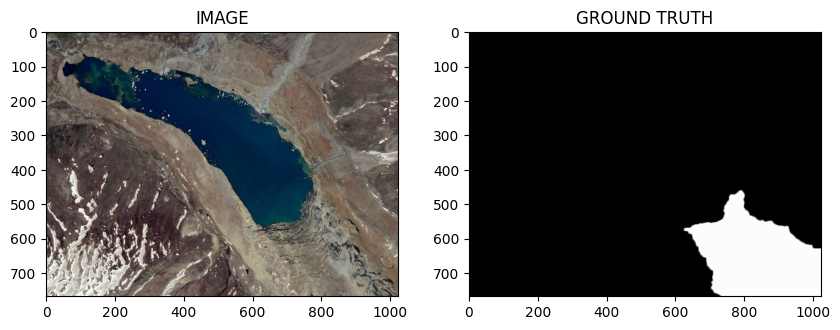

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [16]:
import albumentations as A

In [17]:
def get_train_augs():
  return A.Compose([
      A.Resize(224, 224),
      # A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
                    
                    ], is_check_shapes = 0)

def get_valid_augs():
  return A.Compose([
      A.Resize(224, 224),                    
                    ], is_check_shapes = 0)

In [18]:
from torch.utils.data import Dataset

In [19]:
class SegmentationDataset(Dataset):


  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations 

  def __len__(self):
    return len(self.df) 

  def __getitem__(self, idx):


    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # print(row)
    # print(row.images)
    # print(image)
    # print(image_path)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
    mask = np.expand_dims(mask, axis = -1) 

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) 
      image = data['image'] 
      mask = data['mask'] 

    image = np.transpose(image, (2,0,1)).astype(np.float32) 
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255
    mask = torch.round(torch.Tensor(mask) / 255) 

    return image, mask 

In [20]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [21]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 120
Size of Validset : 30


In [22]:
import matplotlib.image as mpi
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
train_df

,masks,images
22,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
15,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
65,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
11,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
42,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
...,...,...
71,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
106,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
14,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
92,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...


In [24]:
valid_df

,masks,images
73,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
18,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
118,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
78,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
76,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
31,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
64,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
141,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
68,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...
82,/content/drive/MyDrive/Colab Notebooks/Segment...,/content/drive/MyDrive/Colab Notebooks/Segment...


In [25]:
print(trainset)

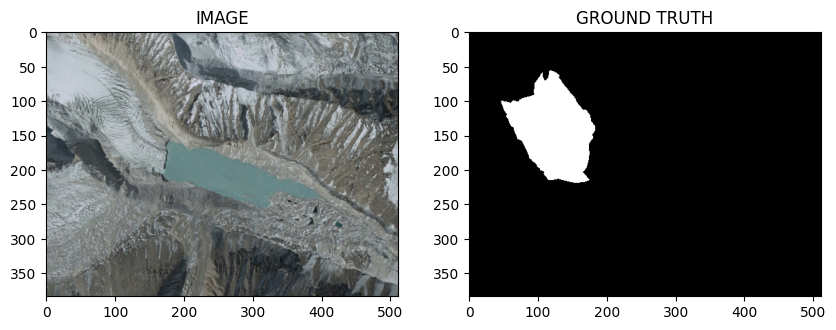

In [26]:
idx = 18

image, mask = validset[idx]
show_image(image, mask)

In [27]:
from torch.utils.data import DataLoader 

In [28]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle =True) 
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [29]:
print(f'total no. of batches in tl : {len(trainloader)}') 
print(f'total no. of batches in vl : {len(validloader)}')

total no. of batches in tl : 40
total no. of batches in vl : 10


In [30]:
for image, mask in trainloader:
  break

  print(f'One batch image shape: {image.shape}') 
  print(f'One batch mask shape: {mask.shape}') 

In [31]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss 

In [32]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [33]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 21.2MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [ ]:
training_plot_loss = []

def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader): 
    
    images = images.to(DEVICE) 
    masks = masks.to(DEVICE) 

    optimizer.zero_grad() 
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step() 

    total_loss += loss.item()

    #exp step
    training_loss = total_loss / len(data_loader)
    training_plot_loss.append(training_loss)
    #exp step

  return training_loss


In [ ]:
validation_plot_loss = []

def eval_fn(data_loader, model, optimizer):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader): 
      images = images.to(DEVICE) 
      masks = masks.to(DEVICE) 

      logits, loss = model(images, masks)
    
      total_loss += loss.item()
      #exp starts
      validation_loss = total_loss / len(data_loader)
      validation_plot_loss.append(validation_loss)

      #exp ends

  return validation_loss


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
import time

best_valid_loss = np.Inf

tic = time.perf_counter()


for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model, optimizer)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/Trained Models/Feature - 3 - Retreating Glacier - Trained Models/Feature-3_150_images_Model_b-0_0.001_150its.pt')
    print("Saved-Model")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss: {valid_loss}")

toc = time.perf_counter()

100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


Saved-Model
Epoch : 1 Train_loss : 0.9987587936222553 Valid_loss: 0.8373632848262786


100%|██████████| 10/10 [00:01<00:00,  9.55it/s]


Saved-Model
Epoch : 2 Train_loss : 0.44213473349809645 Valid_loss: 0.31327409744262696


100%|██████████| 10/10 [00:01<00:00,  9.62it/s]


Saved-Model
Epoch : 3 Train_loss : 0.3178257543593645 Valid_loss: 0.29157157242298126


100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


Saved-Model
Epoch : 4 Train_loss : 0.24928862936794757 Valid_loss: 0.23196210116147994


100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


Saved-Model
Epoch : 5 Train_loss : 0.22130906246602536 Valid_loss: 0.20991745591163635


100%|██████████| 10/10 [00:01<00:00,  9.45it/s]


Saved-Model
Epoch : 6 Train_loss : 0.19896554686129092 Valid_loss: 0.19141725301742554


100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Epoch : 7 Train_loss : 0.1767254713922739 Valid_loss: 0.19626124501228331


100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


Saved-Model
Epoch : 8 Train_loss : 0.15049936510622502 Valid_loss: 0.16197806373238563


100%|██████████| 10/10 [00:01<00:00,  9.53it/s]


Saved-Model
Epoch : 9 Train_loss : 0.1476312905550003 Valid_loss: 0.1556512326002121


100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


Saved-Model
Epoch : 10 Train_loss : 0.13705429807305336 Valid_loss: 0.14831882417201997


100%|██████████| 10/10 [00:01<00:00,  9.30it/s]


Epoch : 11 Train_loss : 0.13441886082291604 Valid_loss: 0.15338480919599534


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Epoch : 12 Train_loss : 0.13815605659037827 Valid_loss: 0.17161135971546174


100%|██████████| 10/10 [00:01<00:00,  9.50it/s]


Epoch : 13 Train_loss : 0.12461004704236985 Valid_loss: 0.17717407271265984


100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Saved-Model
Epoch : 14 Train_loss : 0.12361469734460115 Valid_loss: 0.13390482366085052


100%|██████████| 10/10 [00:01<00:00,  9.42it/s]


Epoch : 15 Train_loss : 0.11376704983413219 Valid_loss: 0.1409758947789669


100%|██████████| 10/10 [00:01<00:00,  9.29it/s]


Epoch : 16 Train_loss : 0.10531792156398297 Valid_loss: 0.15180585756897927


100%|██████████| 10/10 [00:01<00:00,  9.32it/s]


Saved-Model
Epoch : 17 Train_loss : 0.09757049567997456 Valid_loss: 0.13146036565303804


100%|██████████| 10/10 [00:01<00:00,  7.45it/s]


Epoch : 18 Train_loss : 0.08896400481462478 Valid_loss: 0.13247303962707518


100%|██████████| 10/10 [00:01<00:00,  9.20it/s]


Epoch : 19 Train_loss : 0.09403819050639868 Valid_loss: 0.13569114953279496


100%|██████████| 10/10 [00:01<00:00,  9.59it/s]


Epoch : 20 Train_loss : 0.09197212057188153 Valid_loss: 0.1396375097334385


100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


Saved-Model
Epoch : 21 Train_loss : 0.09049783507362008 Valid_loss: 0.11736387684941292


100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Epoch : 22 Train_loss : 0.0825415775179863 Valid_loss: 0.12698684632778168


100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


Epoch : 23 Train_loss : 0.10372370015829802 Valid_loss: 0.17826215997338296


100%|██████████| 10/10 [00:01<00:00,  9.45it/s]


Epoch : 24 Train_loss : 0.10527117066085338 Valid_loss: 0.16890781447291375


100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


Epoch : 25 Train_loss : 0.09897727202624082 Valid_loss: 0.12425486519932746


100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


Epoch : 26 Train_loss : 0.08409263445064426 Valid_loss: 0.13021598756313324


100%|██████████| 10/10 [00:01<00:00,  9.46it/s]


Epoch : 27 Train_loss : 0.08542365683242678 Valid_loss: 0.11919382363557815


100%|██████████| 10/10 [00:01<00:00,  9.42it/s]


Epoch : 28 Train_loss : 0.07547819679602981 Valid_loss: 0.12456073090434075


100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Epoch : 29 Train_loss : 0.06949253343045711 Valid_loss: 0.131525369733572


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Epoch : 30 Train_loss : 0.07013469329103827 Valid_loss: 0.1189333938062191


100%|██████████| 10/10 [00:01<00:00,  9.57it/s]


Epoch : 31 Train_loss : 0.06606101524084806 Valid_loss: 0.12096252888441086


100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Epoch : 32 Train_loss : 0.06742002135142684 Valid_loss: 0.1242631956934929


100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Epoch : 33 Train_loss : 0.06867590518668294 Valid_loss: 0.12155175805091858


100%|██████████| 10/10 [00:01<00:00,  9.50it/s]


Epoch : 34 Train_loss : 0.06309164874255657 Valid_loss: 0.1267460435628891


100%|██████████| 10/10 [00:01<00:00,  9.45it/s]


Epoch : 35 Train_loss : 0.060698583256453276 Valid_loss: 0.1284000463783741


100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Epoch : 36 Train_loss : 0.05770624792203307 Valid_loss: 0.11749189794063568


100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


Saved-Model
Epoch : 37 Train_loss : 0.05680246474221349 Valid_loss: 0.11068731695413589


100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


Saved-Model
Epoch : 38 Train_loss : 0.05487535996362567 Valid_loss: 0.1094551533460617


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Epoch : 39 Train_loss : 0.055564758367836475 Valid_loss: 0.1104389064013958


100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Epoch : 40 Train_loss : 0.05259191831573844 Valid_loss: 0.11286564320325851


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


Saved-Model
Epoch : 41 Train_loss : 0.05307090701535344 Valid_loss: 0.10801680311560631


100%|██████████| 10/10 [00:01<00:00,  9.31it/s]


Epoch : 42 Train_loss : 0.04979065014049411 Valid_loss: 0.11222144663333893


100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


Epoch : 43 Train_loss : 0.04891927596181631 Valid_loss: 0.10887702479958535


100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


Saved-Model
Epoch : 44 Train_loss : 0.04738995581865311 Valid_loss: 0.10691527873277665


100%|██████████| 10/10 [00:01<00:00,  8.96it/s]


Epoch : 45 Train_loss : 0.048253166023641825 Valid_loss: 0.10713538527488708


100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


Epoch : 46 Train_loss : 0.047839317191392186 Valid_loss: 0.11439549252390861


100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


Epoch : 47 Train_loss : 0.04681396698579192 Valid_loss: 0.11947158426046371


100%|██████████| 10/10 [00:01<00:00,  8.90it/s]


Saved-Model
Epoch : 48 Train_loss : 0.04744080267846584 Valid_loss: 0.10493470951914788


100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


Epoch : 49 Train_loss : 0.04790429836139083 Valid_loss: 0.10785416215658188


100%|██████████| 10/10 [00:01<00:00,  9.46it/s]


Epoch : 50 Train_loss : 0.044825105275958774 Valid_loss: 0.10912498012185097


100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


Epoch : 51 Train_loss : 0.045706909243017436 Valid_loss: 0.11033985614776612


100%|██████████| 10/10 [00:01<00:00,  9.21it/s]


Epoch : 52 Train_loss : 0.0424064212013036 Valid_loss: 0.10551834329962731


100%|██████████| 10/10 [00:01<00:00,  9.32it/s]


Epoch : 53 Train_loss : 0.04399384893476963 Valid_loss: 0.1146078273653984


100%|██████████| 10/10 [00:01<00:00,  9.41it/s]


Epoch : 54 Train_loss : 0.04416541634127498 Valid_loss: 0.11253520250320434


100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


Epoch : 55 Train_loss : 0.10073603382334113 Valid_loss: 0.36265284940600395


100%|██████████| 10/10 [00:01<00:00,  9.20it/s]


Epoch : 56 Train_loss : 0.15520977955311538 Valid_loss: 0.2737033605575562


100%|██████████| 10/10 [00:01<00:00,  9.54it/s]


Epoch : 57 Train_loss : 0.13573983274400234 Valid_loss: 0.1755001075565815


100%|██████████| 10/10 [00:01<00:00,  9.08it/s]


Epoch : 58 Train_loss : 0.11618011761456729 Valid_loss: 0.15059070512652398


100%|██████████| 10/10 [00:01<00:00,  9.47it/s]


Epoch : 59 Train_loss : 0.0943349246867001 Valid_loss: 0.14221359938383102


100%|██████████| 10/10 [00:01<00:00,  9.47it/s]


Epoch : 60 Train_loss : 0.07549153044819831 Valid_loss: 0.15051376819610596


100%|██████████| 10/10 [00:01<00:00,  9.47it/s]


Epoch : 61 Train_loss : 0.061131897196173665 Valid_loss: 0.1275249943137169


100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


Epoch : 62 Train_loss : 0.056284189224243164 Valid_loss: 0.11879494935274124


100%|██████████| 10/10 [00:01<00:00,  9.55it/s]


Epoch : 63 Train_loss : 0.05679627051576972 Valid_loss: 0.13475998863577843


100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


Epoch : 64 Train_loss : 0.06260406328365206 Valid_loss: 0.12676097676157952


100%|██████████| 10/10 [00:01<00:00,  9.38it/s]


Epoch : 65 Train_loss : 0.05499457502737641 Valid_loss: 0.11023994013667107


100%|██████████| 10/10 [00:01<00:00,  7.33it/s]


Epoch : 66 Train_loss : 0.0516820958815515 Valid_loss: 0.12477044761180878


100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


Epoch : 67 Train_loss : 0.04870100943371654 Valid_loss: 0.11626267582178115


100%|██████████| 10/10 [00:01<00:00,  9.25it/s]


Epoch : 68 Train_loss : 0.04661147883161902 Valid_loss: 0.11139858961105346


100%|██████████| 10/10 [00:01<00:00,  8.96it/s]


Epoch : 69 Train_loss : 0.04171089120209217 Valid_loss: 0.11251929178833961


100%|██████████| 10/10 [00:01<00:00,  9.07it/s]


Epoch : 70 Train_loss : 0.041669145412743094 Valid_loss: 0.11476791128516198


100%|██████████| 10/10 [00:01<00:00,  9.10it/s]


Epoch : 71 Train_loss : 0.04176493650302291 Valid_loss: 0.11178418397903442


100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


Epoch : 72 Train_loss : 0.037574421241879465 Valid_loss: 0.11171327084302902


100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


Epoch : 73 Train_loss : 0.03825427526608109 Valid_loss: 0.11240459308028221


100%|██████████| 10/10 [00:01<00:00,  9.30it/s]


Epoch : 74 Train_loss : 0.038655426166951654 Valid_loss: 0.10693081319332123


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


Saved-Model
Epoch : 75 Train_loss : 0.03877251222729683 Valid_loss: 0.10252102389931679


100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


Epoch : 76 Train_loss : 0.0397921766154468 Valid_loss: 0.108632842451334


100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


Epoch : 77 Train_loss : 0.038040911220014094 Valid_loss: 0.10905825570225716


100%|██████████| 10/10 [00:01<00:00,  9.20it/s]


Epoch : 78 Train_loss : 0.03627371871843934 Valid_loss: 0.10988973677158356


100%|██████████| 10/10 [00:01<00:00,  9.47it/s]


Epoch : 79 Train_loss : 0.034287955798208716 Valid_loss: 0.10560644194483756


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


Epoch : 80 Train_loss : 0.0342791797593236 Valid_loss: 0.1059196412563324


100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Epoch : 81 Train_loss : 0.034463995462283493 Valid_loss: 0.10997374281287194


100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


Epoch : 82 Train_loss : 0.033176124561578035 Valid_loss: 0.10438423231244087


100%|██████████| 10/10 [00:01<00:00,  9.57it/s]


Epoch : 83 Train_loss : 0.03390041408129037 Valid_loss: 0.10952731370925903


100%|██████████| 10/10 [00:01<00:00,  7.53it/s]


Epoch : 84 Train_loss : 0.032309740828350184 Valid_loss: 0.1076813980937004


100%|██████████| 10/10 [00:01<00:00,  9.62it/s]


Epoch : 85 Train_loss : 0.03248582384549081 Valid_loss: 0.11317102685570717


100%|██████████| 10/10 [00:01<00:00,  9.43it/s]


Epoch : 86 Train_loss : 0.03455209750682116 Valid_loss: 0.10845363661646842


100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


Epoch : 87 Train_loss : 0.03371612727642059 Valid_loss: 0.11116965860128403


100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


Epoch : 88 Train_loss : 0.03376925550401211 Valid_loss: 0.10832678154110909


100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


Epoch : 89 Train_loss : 0.03257996803149581 Valid_loss: 0.10741777569055558


100%|██████████| 10/10 [00:01<00:00,  9.61it/s]


Epoch : 90 Train_loss : 0.032870819140225646 Valid_loss: 0.11111794337630272


100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


Epoch : 91 Train_loss : 0.032422313233837485 Valid_loss: 0.11323136314749718


100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


Epoch : 92 Train_loss : 0.0322234514169395 Valid_loss: 0.11080996841192245


100%|██████████| 10/10 [00:01<00:00,  9.07it/s]


Epoch : 93 Train_loss : 0.033257160289213064 Valid_loss: 0.11441328451037407


100%|██████████| 10/10 [00:01<00:00,  9.41it/s]


Epoch : 94 Train_loss : 0.03216054341755807 Valid_loss: 0.11120187342166901


100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


Epoch : 95 Train_loss : 0.03283206536434591 Valid_loss: 0.11875594109296798


100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


Epoch : 96 Train_loss : 0.03088021408766508 Valid_loss: 0.11436268165707589


100%|██████████| 10/10 [00:01<00:00,  9.33it/s]


Epoch : 97 Train_loss : 0.029236033279448747 Valid_loss: 0.11656678467988968


100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


Epoch : 98 Train_loss : 0.029866231372579932 Valid_loss: 0.10891102701425552


100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch : 99 Train_loss : 0.030824199412018062 Valid_loss: 0.11499051079154014


100%|██████████| 10/10 [00:01<00:00,  9.32it/s]


Epoch : 100 Train_loss : 0.030006752442568542 Valid_loss: 0.1458060309290886


100%|██████████| 10/10 [00:01<00:00,  9.48it/s]


Epoch : 101 Train_loss : 0.0572589635848999 Valid_loss: 0.12489116936922073


100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


Epoch : 102 Train_loss : 0.04748855987563729 Valid_loss: 0.1273891530930996


100%|██████████| 10/10 [00:01<00:00,  9.17it/s]


Epoch : 103 Train_loss : 0.05161525998264551 Valid_loss: 0.11322693973779678


100%|██████████| 10/10 [00:01<00:00,  9.30it/s]


Epoch : 104 Train_loss : 0.03943787626922131 Valid_loss: 0.11256332844495773


100%|██████████| 10/10 [00:01<00:00,  9.29it/s]


Epoch : 105 Train_loss : 0.03722265670076012 Valid_loss: 0.12087389826774597


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Epoch : 106 Train_loss : 0.031542450189590454 Valid_loss: 0.11506199911236763


100%|██████████| 10/10 [00:01<00:00,  9.33it/s]


Epoch : 107 Train_loss : 0.03536762376315892 Valid_loss: 0.11549554914236068


100%|██████████| 10/10 [00:01<00:00,  9.45it/s]


Epoch : 108 Train_loss : 0.033496157452464106 Valid_loss: 0.11514634415507316


100%|██████████| 10/10 [00:01<00:00,  9.31it/s]


Epoch : 109 Train_loss : 0.03117172042839229 Valid_loss: 0.11190147176384926


100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


Epoch : 110 Train_loss : 0.030124965123832226 Valid_loss: 0.11181249916553497


100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


Epoch : 111 Train_loss : 0.034858223889023064 Valid_loss: 0.12119494751095772


100%|██████████| 10/10 [00:01<00:00,  9.03it/s]


Epoch : 112 Train_loss : 0.042173547111451624 Valid_loss: 0.13397076949477196


100%|██████████| 10/10 [00:01<00:00,  9.20it/s]


Epoch : 113 Train_loss : 0.0657659531570971 Valid_loss: 0.2819237977266312


100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Epoch : 114 Train_loss : 0.0689138626679778 Valid_loss: 0.14944103881716728


100%|██████████| 10/10 [00:01<00:00,  9.13it/s]


Epoch : 115 Train_loss : 0.05822228109464049 Valid_loss: 0.2045146718621254


100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


Epoch : 116 Train_loss : 0.11890592882409692 Valid_loss: 0.18646081835031508


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Epoch : 117 Train_loss : 0.08683988554403185 Valid_loss: 0.15791048109531403


100%|██████████| 10/10 [00:01<00:00,  9.45it/s]


Epoch : 118 Train_loss : 0.06799833467230201 Valid_loss: 0.1505605734884739


100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


Epoch : 119 Train_loss : 0.06420052638277411 Valid_loss: 0.16650732308626176


100%|██████████| 10/10 [00:01<00:00,  9.31it/s]


Epoch : 120 Train_loss : 0.05228190515190363 Valid_loss: 0.1395978346467018


100%|██████████| 10/10 [00:01<00:00,  7.45it/s]


Epoch : 121 Train_loss : 0.07362008774653077 Valid_loss: 0.18391432389616966


100%|██████████| 10/10 [00:01<00:00,  9.19it/s]


Epoch : 122 Train_loss : 0.064160873927176 Valid_loss: 0.1499045193195343


100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


Epoch : 123 Train_loss : 0.05959793794900179 Valid_loss: 0.1394106164574623


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


Epoch : 124 Train_loss : 0.045445343106985094 Valid_loss: 0.11927821412682534


100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


Epoch : 125 Train_loss : 0.04589916137047112 Valid_loss: 0.13106247261166573


100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


Epoch : 126 Train_loss : 0.03865932300686836 Valid_loss: 0.1315412200987339


100%|██████████| 10/10 [00:01<00:00,  9.50it/s]


Epoch : 127 Train_loss : 0.03605438424274325 Valid_loss: 0.12148754820227622


100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


Epoch : 128 Train_loss : 0.03274408085271716 Valid_loss: 0.12373310923576356


100%|██████████| 10/10 [00:01<00:00,  9.47it/s]


Epoch : 129 Train_loss : 0.030899954913184046 Valid_loss: 0.1251342035830021


100%|██████████| 10/10 [00:01<00:00,  9.49it/s]


Epoch : 130 Train_loss : 0.030952195497229697 Valid_loss: 0.12670411467552184


100%|██████████| 10/10 [00:01<00:00,  9.47it/s]


Epoch : 131 Train_loss : 0.029214214347302914 Valid_loss: 0.12547171264886856


100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


Epoch : 132 Train_loss : 0.027123262407258153 Valid_loss: 0.12834412306547166


100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


Epoch : 133 Train_loss : 0.025281501468271017 Valid_loss: 0.1310139589011669


100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


Epoch : 134 Train_loss : 0.02721073655411601 Valid_loss: 0.12765245288610458


100%|██████████| 10/10 [00:01<00:00,  9.37it/s]


Epoch : 135 Train_loss : 0.03177388454787433 Valid_loss: 0.12881213203072547


100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


Epoch : 136 Train_loss : 0.029392093420028687 Valid_loss: 0.12478737458586693


100%|██████████| 10/10 [00:01<00:00,  9.72it/s]


Epoch : 137 Train_loss : 0.028167649777606128 Valid_loss: 0.12624987959861755


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


Epoch : 138 Train_loss : 0.026207474013790488 Valid_loss: 0.12820748537778853


100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Epoch : 139 Train_loss : 0.026712346309795975 Valid_loss: 0.12569951191544532


100%|██████████| 10/10 [00:01<00:00,  9.51it/s]


Epoch : 140 Train_loss : 0.02495857561007142 Valid_loss: 0.12463829591870308


100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


Epoch : 141 Train_loss : 0.023831779696047307 Valid_loss: 0.12613115459680557


100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


Epoch : 142 Train_loss : 0.025272301211953164 Valid_loss: 0.12690707743167878


100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Epoch : 143 Train_loss : 0.02387561774812639 Valid_loss: 0.12910515442490578


100%|██████████| 10/10 [00:01<00:00,  9.38it/s]


Epoch : 144 Train_loss : 0.022635971195995808 Valid_loss: 0.12735430747270585


100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


Epoch : 145 Train_loss : 0.023487819684669377 Valid_loss: 0.1306240439414978


100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


Epoch : 146 Train_loss : 0.02235454637557268 Valid_loss: 0.12744773104786872


100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Epoch : 147 Train_loss : 0.022825285606086255 Valid_loss: 0.12947069928050042


100%|██████████| 10/10 [00:01<00:00,  9.41it/s]


Epoch : 148 Train_loss : 0.022017599223181604 Valid_loss: 0.12666723877191544


100%|██████████| 10/10 [00:01<00:00,  9.41it/s]


Epoch : 149 Train_loss : 0.020910596358589828 Valid_loss: 0.12843286320567132


100%|██████████| 10/10 [00:01<00:00,  7.66it/s]

Epoch : 150 Train_loss : 0.022099256934598088 Valid_loss: 0.12736729830503463


In [ ]:
# Time taken in Training 
print(f"Time taken for training with {EPOCHS} Epochs,    LR: {LR},    Model:{ENCODER}      is {(toc-tic)/60} Minutes")

Time taken for training with 150 Epochs,    LR: 0.001,    Model:timm-efficientnet-b0      is 24.090519127533334 Minutes


In [ ]:
print(training_plot_loss)
print(validation_plot_loss)

[0.04064924120903015, 0.07982887327671051, 0.11810681521892548, 0.1555022805929184, 0.1902744859457016, 0.2260107070207596, 0.2596308469772339, 0.2918338179588318, 0.32326828241348265, 0.35395048260688783, 0.38088489770889283, 0.410187304019928, 0.4365210890769958, 0.46300270557403567, 0.48835343718528745, 0.5115668118000031, 0.5360492885112762, 0.5601777881383896, 0.5843189358711243, 0.6078522354364395, 0.6323561891913414, 0.6523237839341164, 0.672190448641777, 0.6944852069020271, 0.7142662316560745, 0.7353268966078759, 0.7549797281622886, 0.7749839380383492, 0.7928030282258988, 0.8107060268521309, 0.8328778564929962, 0.8508349239826203, 0.8709996819496155, 0.8920867353677749, 0.9115887850522995, 0.9315544202923774, 0.9438954964280128, 0.9642166018486023, 0.9869372516870498, 0.9987587936222553, 0.011443303525447845, 0.025394776463508607, 0.03752456605434418, 0.05200356841087341, 0.06738218665122986, 0.08084034323692321, 0.09647337943315507, 0.1075580395758152, 0.11747223809361458, 0.1

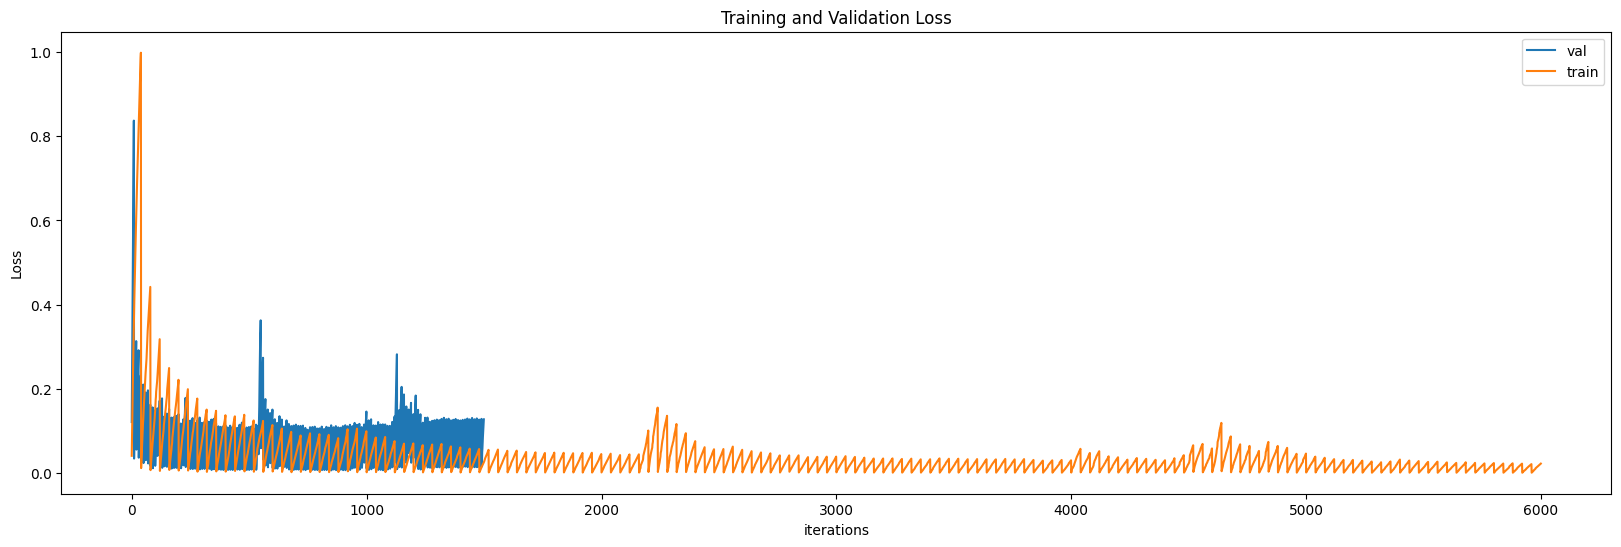

In [ ]:
# Experiment cell for plotting graph

plt.figure(figsize=(20, 6))
plt.title("Training and Validation Loss")
plt.plot(validation_plot_loss,label="val")
plt.plot(training_plot_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
idx = 1

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/Trained Models/Feature - 3 - Retreating Glacier - Trained Models/Feature-3_150_images_Model_b-0_0.001_150its.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C,H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

In [ ]:
# result_1 = pred_mask.detach().cpu().squeeze(0)

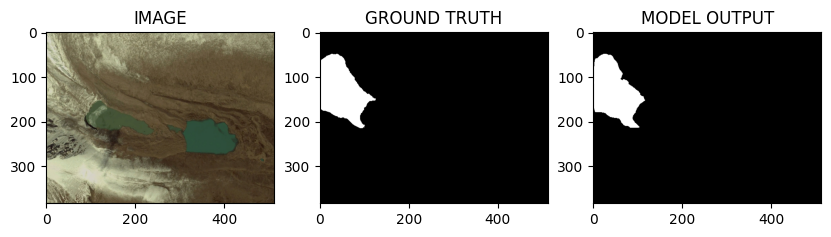

In [ ]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [34]:
idx = 0

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/Trained Models/Feature - 3 - Retreating Glacier - Trained Models/Feature-3_150_images_Model_b-0_0.001_150its.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C,H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

# Model Output Part
result_1 = pred_mask.detach().cpu().squeeze(0)
saving = result_1.squeeze(0)
saving = saving.numpy()
saving_rgb = cv2.cvtColor(saving, cv2.COLOR_BGR2RGB)

# Original Mask Part
mask_new = mask.squeeze(0)
mask_new = mask_new.numpy()
mask_new_rgb = cv2.cvtColor(mask_new, cv2.COLOR_BGR2RGB)

#iou_score for this given Index
intersection = np.logical_and(mask_new_rgb, saving_rgb)
union = np.logical_or(mask_new_rgb, saving_rgb)
iou_score = np.sum(intersection) / np.sum(union)

print(iou_score)

0.9159463750220498


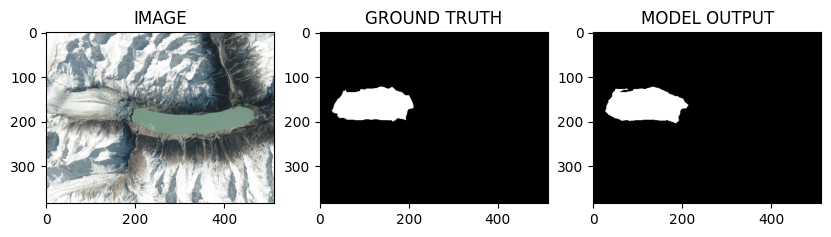

In [35]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [41]:
# Code for Exact Feature Extraction "

idx = 1

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Segmentation_DL_data/Trained Models/Feature - 3 - Retreating Glacier - Trained Models/Feature-3_150_images_Model_b-0_0.001_150its.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C,H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

input_image_tn = image
pred_image_tn = pred_mask.detach().cpu().squeeze(0)

vis_input_image_tn = np.squeeze(input_image_tn)
vis_pred_image_tn = pred_image_tn

vis_input_image_tn_np = vis_input_image_tn.numpy()
vis_pred_image_tn_np = vis_pred_image_tn.numpy()

converted = vis_input_image_tn_np * vis_pred_image_tn_np

vis_input_image_tn_np = cv2.merge((vis_input_image_tn_np[2], vis_input_image_tn_np[1], vis_input_image_tn_np[0]))
vis_input_image_tn_np = cv2.cvtColor(vis_input_image_tn_np, cv2.COLOR_BGR2RGB)

converted_1 = cv2.merge((converted[2], converted[1], converted[0]))
converted_2 = cv2.cvtColor(converted_1, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Extracted Feature: Part of Retreating Glacier')

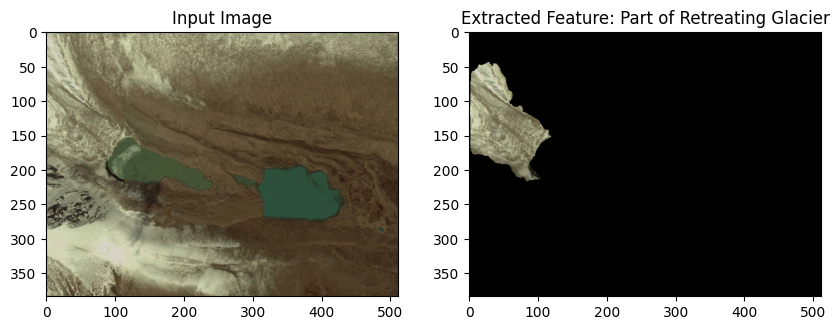

In [42]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)
plt.imshow(vis_input_image_tn_np)
# plt.axis('off')
plt.title("Input Image")

fig.add_subplot(1, 2, 2)
plt.imshow(converted_2)
# plt.axis('off')
plt.title("Extracted Feature: Part of Retreating Glacier")